In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import gaussian_kde
from pathlib import Path
from scipy.stats import (
    chi2, lognorm, gamma, gengamma, weibull_min, fisk, burr, betaprime, geninvgauss,
    expon, lomax, genpareto, pareto, invweibull, invgamma, invgauss, loggamma, norm 
)

In [20]:
msi_csv = "/storage/scratch1/2/yhao306/sma-brain/data-sm/V11L12-038_A1_MSI_raw_counts_spotRows.csv"
msi_df = pd.read_csv(msi_csv, index_col=0)
coord_csv = "/storage/scratch1/2/yhao306/sma-brain/data-sm/V11L12-038_A1_spot_coordinates.csv"
coords_df = pd.read_csv(coord_csv, index_col=0) 
msi_csv = "../msi_norm.csv"
msi_norm = pd.read_csv(msi_csv, index_col=0)
msi_norm_hvg = "../msi_norm_hvg.csv"
msi_norm_hvg = pd.read_csv(msi_norm_hvg, index_col=0)
msi_csv_hvg = "../msi_df_hvg.csv"
msi_df_hvg = pd.read_csv(msi_csv_hvg, index_col=0)
rna_norm_hvg = "../rna_norm_hvg.csv"
rna_norm_hvg = pd.read_csv(rna_norm_hvg, index_col=0)
rna_csv = "../rna_norm.csv"
rna_norm = pd.read_csv(rna_csv, index_col=0)
region_csv = "/storage/scratch1/2/yhao306/sma-brain/data-sm/sma/V11L12-038/V11L12-038_A1/output_data/V11L12-038_A1_RNA/outs/RegionLoupe.csv"
region_df = pd.read_csv(region_csv, index_col=0)
region_df.index = region_df.index + "_1"
print(region_df)
common_barcodes = rna_norm.index
region_df = region_df.loc[common_barcodes]
print(region_df)
region_df.index.name = 'barcode'
coords_df.index.name = 'barcode'
coords_small = coords_df[['x', 'y']]
df_merged = region_df.join(coords_small, how='inner')
print(df_merged.head())
deconv = pd.read_csv("../deconvolution.tsv", sep="\t", index_col=0)
df_final  = df_merged.join(deconv, how="inner")
df_final  = df_final.reset_index()
df_final = df_final.set_index("index")
cell_types = [c for c in df_final.columns if c not in ['RegionLoupe','x','y']]
prop_df = df_final[cell_types]
print(prop_df)

                     RegionLoupe
Barcode                         
AAACAAGTATCTCCCA-1_1          CP
AAACAGCTTTCAGAAG-1_1         CTX
AAACAGGGTCTATATT-1_1         NaN
AAACATTTCCCGGATT-1_1          cc
AAACCCGAACGAAATC-1_1          CP
...                          ...
TTGTTCAGTGTGCTAC-1_1         ACB
TTGTTCTAGATACGCT-1_1         CTX
TTGTTGTGTGTCAAGA-1_1         PAL
TTGTTTCCATACAACT-1_1         CTX
TTGTTTGTGTAAATTC-1_1         NaN

[2856 rows x 1 columns]
                     RegionLoupe
TGGGCACAAACAGAAC-1_1         NaN
TTGGAGTCTCCCTTCT-1_1         NaN
AATATCAAGGTCGGAT-1_1         CTX
CACCCTTTCCTCGCTC-1_1         CTX
CTGGTTCAACGCATCA-1_1         CTX
...                          ...
GCTCAACCTCTTAGAG-1_1         CTX
GGGCGAATTTCTCCAC-1_1         CTX
TGAAGTAGCTTACGGA-1_1         CTX
TACATCTTGTTTCTTG-1_1         CTX
CAGTAGATGATGTCCG-1_1         CTX

[2386 rows x 1 columns]
                     RegionLoupe   x  y
barcode                                
TGGGCACAAACAGAAC-1_1         NaN  46  8
TTGGA

In [4]:
print(msi_norm_hvg)

                      136.06234  146.16571  146.982305  162.11258500000002  \
TGGGCACAAACAGAAC-1_1   3.925959   1.835959    1.521772            3.818272   
TTGGAGTCTCCCTTCT-1_1   4.766409   4.216749    1.211039            4.216488   
AATATCAAGGTCGGAT-1_1   4.301785   2.919628    0.868285            3.183134   
CACCCTTTCCTCGCTC-1_1   3.417170   2.642499    1.179522            3.198720   
CTGGTTCAACGCATCA-1_1   4.167663   3.237248    1.206054            3.602747   
...                         ...        ...         ...                 ...   
GCTCAACCTCTTAGAG-1_1   4.681761   2.800235    1.362776            3.762866   
GGGCGAATTTCTCCAC-1_1   5.455012   2.473381    1.076602            3.771071   
TGAAGTAGCTTACGGA-1_1   4.605897   3.287055    1.453160            4.161796   
TACATCTTGTTTCTTG-1_1   4.628752   2.684328    1.302188            3.972417   
CAGTAGATGATGTCCG-1_1   5.106971   2.106050    1.369627            3.438777   

                      162.11293999999998  163.11623  165.066415

# Real KL

In [17]:
idx = msi_df_hvg.index.intersection(region_df.index)
X = msi_df_hvg.loc[idx]
region = region_df.loc[idx, "RegionLoupe"].astype("category")
X_lin = X.copy()
mean_by_region = X_lin.groupby(region).mean()
den = mean_by_region.sum(axis=0).replace(0, np.nan)
prob = (mean_by_region / den).T.fillna(0.0)
prob.index.name = "metabolite"
prob.columns.name = "region"
prob.to_csv("metabolite_region_mean_fraction.csv")
print(prob)
bgp = prob.mean(axis=0)
bgp = bgp / bgp.sum()   
print(bgp)

region                   ACB        CP       CTX       LSX        OT  \
metabolite                                                             
136.06234           0.128533  0.120668  0.115016  0.120275  0.130200   
146.16571           0.093040  0.104272  0.092690  0.109811  0.085076   
146.982305          0.109631  0.120638  0.108324  0.146861  0.111687   
162.11258500000002  0.134982  0.100972  0.061755  0.154717  0.089165   
162.11293999999998  0.132222  0.101108  0.062713  0.152715  0.089116   
...                      ...       ...       ...       ...       ...   
966.52592           0.120757  0.169665  0.173958  0.102033  0.135887   
966.549985          0.024696  0.061024  0.049951  0.047073  0.081673   
966.927925          0.106477  0.084406  0.110952  0.114396  0.116831   
992.560465          0.136313  0.109975  0.100860  0.137667  0.091949   
992.614545          0.112659  0.095529  0.093745  0.120530  0.113472   

region                   PAL        VL       aco        cc  
me

/tmp/ipykernel_2397506/3684836006.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_region = X_lin.groupby(region).mean()


In [18]:
P = prob.copy()
q = bgp.reindex(P.columns).astype(float) 

eps = 1e-12
P = P.clip(lower=0)
P = P.div(P.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0) 
q = q.clip(lower=0); q = q / q.sum() 

KL_contrib = P.mul(np.log(P + eps).sub(np.log(q.values + eps)), axis=0)
KL = KL_contrib.sum(axis=1).rename("KL(p||q)")
print(KL)

metabolite
136.06234             0.009218
146.16571             0.018248
146.982305            0.049194
162.11258500000002    0.037989
162.11293999999998    0.035082
                        ...   
966.52592             0.081398
966.549985            0.321594
966.927925            0.025065
992.560465            0.041110
992.614545            0.019613
Name: KL(p||q), Length: 500, dtype: float64


In [50]:
eps = 1e-12
P = prob.copy().clip(lower=0)
P = P.div(P.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

q = bgp.reindex(P.columns).astype(float).clip(lower=0)
q = q / q.sum()

LR = np.log(P + eps).sub(np.log(q + eps), axis=1) 
C  = P * LR 

KL = C.sum(axis=1).rename("KL(p||q)")

C.index.name = "metabolite"; C.columns.name = "region"
LR.index.name = "metabolite"; LR.columns.name = "region"
KL.index.name = "metabolite"

rmoutdir = Path("regional_associated")
rmoutdir.mkdir(parents=True, exist_ok=True)

C.to_csv(rmoutdir/"kl_contrib_by_region.csv")
LR.to_csv(rmoutdir/"log_ratio_by_region.csv") 
KL.to_csv(rmoutdir/"kl_per_metabolite.csv")

print("KL summary (nat units):")
print(KL.describe())

KL summary (nat units):
count    500.000000
mean       0.068665
std        0.075209
min        0.001225
25%        0.023378
50%        0.043608
75%        0.084877
max        0.793459
Name: KL(p||q), dtype: float64


# KL_NULL

In [39]:
msi_df_null = pd.read_csv("msi_df_null.csv", index_col = 0)
print(msi_df_null)

                         136.06234      146.16571     146.982305  \
barcode                                                            
TGGGCACAAACAGAAC-1_1  1.066344e+06  586447.312500   47931.695312   
TTGGAGTCTCCCTTCT-1_1  1.546114e+06  345932.343750       0.000000   
AATATCAAGGTCGGAT-1_1  1.129812e+06  208245.796875   76413.242188   
CACCCTTTCCTCGCTC-1_1  4.276984e+05  755784.812500   63515.132812   
CTGGTTCAACGCATCA-1_1  1.619928e+06  269171.312500   49622.203125   
...                            ...            ...            ...   
GCTCAACCTCTTAGAG-1_1  1.145824e+06  499247.468750  151691.843750   
GGGCGAATTTCTCCAC-1_1  1.563168e+06  154406.671875  157307.765625   
TGAAGTAGCTTACGGA-1_1  2.053317e+06  282783.593750  212094.109375   
TACATCTTGTTTCTTG-1_1  1.394756e+06  430058.843750  144180.343750   
CAGTAGATGATGTCCG-1_1  1.786307e+06  524420.937500   31280.388672   

                      162.11258500000002  162.11293999999998      163.11623  \
barcode                             

In [40]:
idx = msi_df_null.index.intersection(region_df.index)
X = msi_df_null.loc[idx]
region = region_df.loc[idx, "RegionLoupe"].astype("category")
X_lin = X.copy()
mean_by_region = X_lin.groupby(region).mean()
den = mean_by_region.sum(axis=0).replace(0, np.nan)
prob_null = (mean_by_region / den).T.fillna(0.0)
prob_null.index.name = "metabolite"
prob_null.columns.name = "region"
# prob.to_csv("metabolite_region_mean_fraction.csv")
print(prob_null)
bgp_null = prob_null.mean(axis=0)
bgp_null = bgp_null / bgp_null.sum()   
print(bgp_null)

region                   ACB        CP       CTX       LSX        OT  \
metabolite                                                             
136.06234           0.114403  0.104916  0.117464  0.112422  0.106384   
146.16571           0.104075  0.096649  0.095773  0.146746  0.087665   
146.982305          0.098855  0.128919  0.121650  0.108268  0.113676   
162.11258500000002  0.116334  0.077447  0.078923  0.159725  0.075011   
162.11293999999998  0.126867  0.079183  0.078494  0.153153  0.091141   
...                      ...       ...       ...       ...       ...   
966.52592           0.106744  0.144370  0.128637  0.088020  0.183015   
966.549985          0.103665  0.073538  0.085893  0.145376  0.068944   
966.927925          0.127164  0.126239  0.108974  0.080798  0.152201   
992.560465          0.104149  0.123531  0.133360  0.123602  0.080998   
992.614545          0.099250  0.103635  0.117890  0.117637  0.096914   

region                   PAL        VL       aco        cc  
me

/tmp/ipykernel_2397506/4074338360.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_region = X_lin.groupby(region).mean()


In [41]:
P_null = prob_null.copy()
q_null = bgp_null.reindex(P_null.columns).astype(float) 

eps = 1e-12
P_null = P_null.clip(lower=0)
P_null = P_null.div(P_null.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0) 
q_null = q_null.clip(lower=0); q_null = q_null / q_null.sum() 

KL_contrib = P_null.mul(np.log(P_null + eps).sub(np.log(q_null.values + eps)), axis=0)
KL_null = KL_contrib.sum(axis=1).rename("KL(p||q)")      
print(KL_null)

metabolite
136.06234             0.000980
146.16571             0.017233
146.982305            0.002493
162.11258500000002    0.043945
162.11293999999998    0.029983
                        ...   
966.52592             0.078214
966.549985            0.076321
966.927925            0.018517
992.560465            0.037000
992.614545            0.004161
Name: KL(p||q), Length: 500, dtype: float64


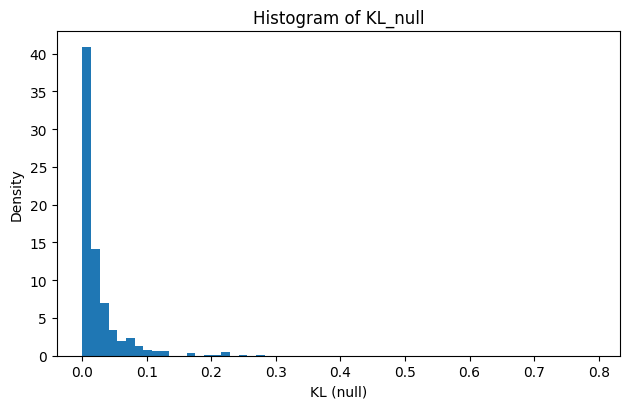

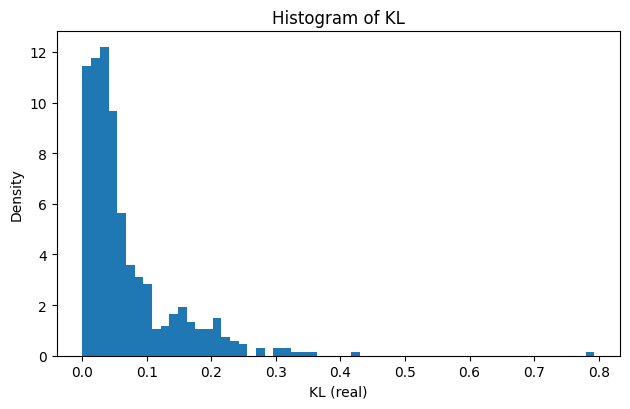

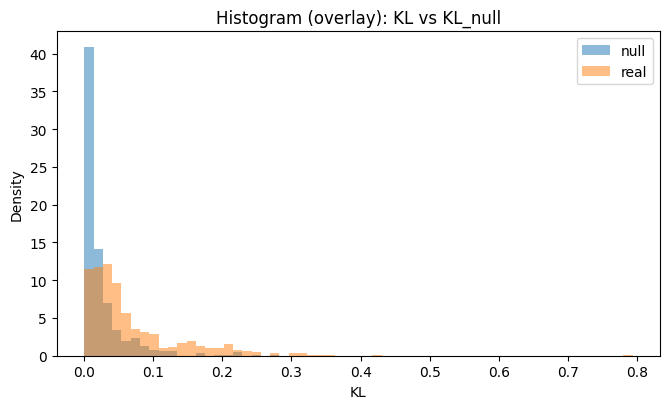

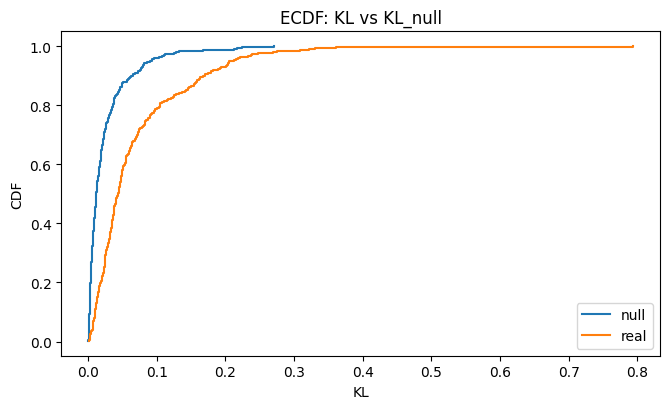

         KL_null     KL_real
n     500.000000  500.000000
mean    0.024709    0.068665
std     0.036143    0.075209
p1      0.000542    0.002117
p50     0.011664    0.043608
p99     0.212875    0.321682
min     0.000421    0.001225
max     0.270126    0.793459


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def to_numeric_1d(obj):
    if isinstance(obj, pd.Series):
        arr = pd.to_numeric(obj, errors="coerce").to_numpy()
    elif isinstance(obj, pd.DataFrame):
        num = obj.select_dtypes(include=[np.number])
        arr = pd.to_numeric(num.to_numpy().ravel(), errors="coerce")
    else:
        arr = np.asarray(obj).ravel()
    arr = arr[np.isfinite(arr)]
    return arr

def ecdf(a):
    a = np.sort(np.asarray(a))
    n = a.size
    y = np.arange(1, n+1) / n
    return a, y

vals_null = to_numeric_1d(KL_null)
vals_real = to_numeric_1d(KL)

# lo = np.percentile(np.concatenate([vals_null, vals_real]), 0.5)
# hi = np.percentile(np.concatenate([vals_null, vals_real]), 99.5)
# if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
#     lo, hi = float(np.min([vals_null.min(), vals_real.min()])), float(np.max([vals_null.max(), vals_real.max()]))
#     if lo == hi:
#         lo, hi = lo - 1e-6, hi + 1e-6

# bins = np.linspace(lo, hi, 60)

lo = min(vals_null.min(), vals_real.min())
hi = max(vals_null.max(), vals_real.max())
bins = np.linspace(lo, hi, 60)
# bins = "auto"


outdir = Path("KL_plots")
outdir.mkdir(exist_ok=True)

plt.figure(figsize=(6.4, 4.2))
plt.hist(vals_null, bins=bins, density=True)
plt.xlabel("KL (null)")
plt.ylabel("Density")
plt.title("Histogram of KL_null")
plt.tight_layout()
plt.savefig(outdir / "KL_hist_null.png", dpi=200)
plt.show()

plt.figure(figsize=(6.4, 4.2))
plt.hist(vals_real, bins=bins, density=True)
plt.xlabel("KL (real)")
plt.ylabel("Density")
plt.title("Histogram of KL")
plt.tight_layout()
plt.savefig(outdir / "KL_hist_real.png", dpi=200)
plt.show()

plt.figure(figsize=(6.8, 4.2))
plt.hist(vals_null, bins=bins, density=True, alpha=0.5, label="null", edgecolor="none")
plt.hist(vals_real, bins=bins, density=True, alpha=0.5, label="real", edgecolor="none")
plt.xlabel("KL")
plt.ylabel("Density")
plt.title("Histogram (overlay): KL vs KL_null")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(outdir / "KL_hist_overlay.png", dpi=200)
plt.show()

x0, F0 = ecdf(vals_null)
x1, F1 = ecdf(vals_real)

plt.figure(figsize=(6.8, 4.2))
plt.step(x0, F0, where="post", label="null")
plt.step(x1, F1, where="post", label="real")
plt.xlabel("KL")
plt.ylabel("CDF")
plt.title("ECDF: KL vs KL_null")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(outdir / "KL_ecdf_overlay.png", dpi=200)
plt.show()


def summarize(a, name):
    return pd.Series({
        "n": a.size,
        "mean": np.mean(a),
        "std": np.std(a, ddof=1) if a.size > 1 else 0.0,
        "p1": np.percentile(a, 1),
        "p50": np.percentile(a, 50),
        "p99": np.percentile(a, 99),
        "min": np.min(a),
        "max": np.max(a),
    }, name=name)

summary = pd.concat([summarize(vals_null, "KL_null"),
                     summarize(vals_real, "KL_real")], axis=1)
summary.to_csv(outdir / "KL_summary_stats.csv")
print(summary)


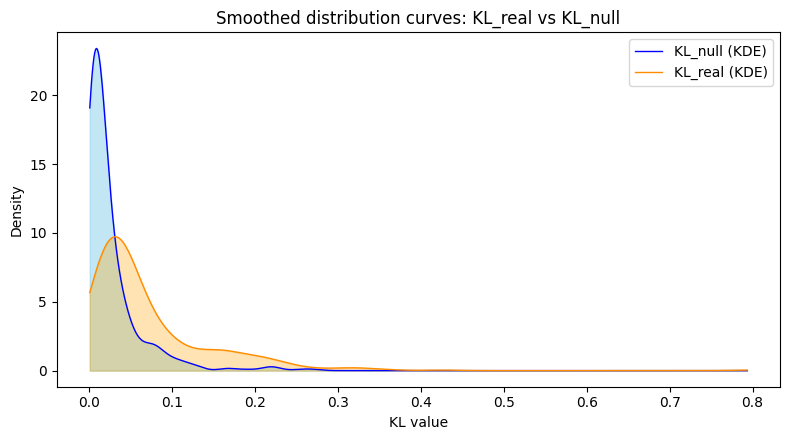

Saved: /storage/project/r-ssinha338-0/yhao306/sma/Analysis/MANTIS/regional_associated/KL_plots/KL_kde_overlay.png


In [53]:
def to_numeric_1d(obj):
    if isinstance(obj, pd.Series):
        arr = pd.to_numeric(obj, errors="coerce").to_numpy()
    elif isinstance(obj, pd.DataFrame):
        num = obj.select_dtypes(include=[np.number])
        arr = pd.to_numeric(num.to_numpy().ravel(), errors="coerce")
    else:
        arr = np.asarray(obj).ravel().astype(float, copy=False)
    arr = arr[np.isfinite(arr)]
    return arr

real_candidates = ["KL", "KL"]
null_candidates = ["KL_null", "KL_null"]

real_obj = None
null_obj = None

for name in real_candidates:
    if name in globals():
        real_obj = globals()[name]
        break
for name in null_candidates:
    if name in globals():
        null_obj = globals()[name]
        break


vals_real = to_numeric_1d(real_obj)
vals_null = to_numeric_1d(null_obj)


def safe_kde(vals):
    if vals.size < 2:
        return None
    try:
        return gaussian_kde(vals)
    except Exception as e:
        print("gaussian_kde failed:", e)
        return None

kde_real = safe_kde(vals_real)
kde_null = safe_kde(vals_null)

xmin = min(vals_real.min(), vals_null.min())
xmax = max(vals_real.max(), vals_null.max())
if xmax - xmin < 1e-12:
    xmin -= 1e-6
    xmax += 1e-6

x = np.linspace(xmin, xmax, 800)

outdir = Path(rmoutdir/"KL_plots")
outdir.mkdir(exist_ok=True)

plt.figure(figsize=(8, 4.5))


if kde_null is not None:
    y_null = kde_null(x)
    plt.fill_between(x, y_null, alpha=0.5, color="skyblue")
    plt.plot(x, y_null, color="blue", lw=1.0, label="KL_null (KDE)")
else:
    print("Warning: null KDE not computed (insufficient/degenerate data).")

if kde_real is not None:
    y_real = kde_real(x)
    plt.fill_between(x, y_real, alpha=0.3, color="orange")
    plt.plot(x, y_real, color="darkorange", lw=1.0, label="KL_real (KDE)")
else:
    print("Warning: real KDE not computed (insufficient/degenerate data).")

plt.xlabel("KL value")
plt.ylabel("Density")
plt.title("Smoothed distribution curves: KL_real vs KL_null")
plt.legend()
plt.tight_layout()

png_path = outdir / "KL_kde_overlay.png"
plt.savefig(png_path, dpi=200)
plt.show()

print("Saved:", png_path.resolve())


In [43]:
import numpy as np
import pandas as pd
from scipy.stats import (
    chi2, lognorm, gamma, gengamma, weibull_min, fisk, burr, betaprime, geninvgauss,
    expon,
    lomax,
    genpareto,
    pareto,
    invweibull,
    invgamma,
    invgauss,
    loggamma,
    norm 
)

vals_real = to_numeric_1d(KL)
vals_null = to_numeric_1d(KL_null)

vals = np.asarray(vals_null, float)
vals = vals[np.isfinite(vals)]
vals = np.clip(vals, 1e-15, np.inf)
n = vals.size

candidates = {
    "chi2":         chi2,         # df, loc, scale
    "lognorm":      lognorm,      # s,  loc, scale
    "gamma":        gamma,        # a,  loc, scale
    "gengamma":     gengamma,     # a, c, loc, scale
    "weibull_min":  weibull_min,  # c,  loc, scale
    "fisk":         fisk,         # c,  loc, scale (log-logistic)
    "burr":         burr,         # c, d, loc, scale
    "betaprime":    betaprime,    # a, b, loc, scale
    "geninvgauss":  geninvgauss,  # p, b, loc, scale (GIG)
    "expon":        expon,        # (loc, scale)
    "lomax":        lomax,        # (c, loc, scale)
    "genpareto":    genpareto,    # (c, loc, scale)
    "pareto":       pareto,       # (b, loc, scale)
    "invweibull":   invweibull,   # (c, loc, scale)
    "invgamma":     invgamma,     # (a, loc, scale)
    "invgauss":     invgauss,     # (mu, loc, scale)
    "loggamma":     loggamma,     # (c, loc, scale)
    "norm":         norm          # (loc, scale)
}

def _ad_statistic(x, cdf, eps=1e-12):

    x = np.sort(np.asarray(x, float))
    n = x.size
    u = np.clip(cdf(x), eps, 1.0 - eps)  # 防 log(0)
    i = np.arange(1, n + 1)
    A2 = -n - (1.0 / n) * np.sum((2 * i - 1) * (np.log(u) + np.log(1.0 - u[::-1])))
    return float(A2)

def _ad_pvalue_naive(A2, n):

    A = A2 * (1.0 + 0.75 / n + 2.25 / (n * n))
    if A < 0.2:
        p = 1.0 - np.exp(-13.436 + 101.14 * A - 223.73 * A * A)
    elif A < 0.34:
        p = 1.0 - np.exp(-8.318 + 42.796 * A - 59.938 * A * A)
    elif A < 0.6:
        p = np.exp(0.9177 - 4.279 * A - 1.38 * A * A)
    else:
        p = np.exp(1.2937 - 5.709 * A + 0.0186 * A * A)
    return float(np.clip(p, 0.0, 1.0)), float(A)

def fit_and_AD_naive(name, dist):
    res = {"dist": name}
    try:
        params = dist.fit(vals, floc=0.0)
        res["params"] = params

        D_obs, p_ks = kstest(vals, lambda x: dist.cdf(x, *params))
        res["KS_D_naive"] = float(D_obs)
        res["KS_p_naive"] = float(p_ks)

        A2 = _ad_statistic(vals, lambda t: dist.cdf(t, *params))
        p_ad, A2_star = _ad_pvalue_naive(A2, n)
        res["AD_A2"] = float(A2)
        res["AD_A2_star"] = float(A2_star)
        res["AD_p_naive"] = float(p_ad)
    except Exception as e:
        res["error"] = str(e)
    return res

rows = [fit_and_AD_naive(name, dist) for name, dist in candidates.items()]
fit_table = (
    pd.DataFrame(rows)
      .sort_values(by=["AD_p_naive", "KS_p_naive"], ascending=False)
      .reset_index(drop=True)
)

fit_table

,dist,params,KS_D_naive,KS_p_naive,AD_A2,AD_A2_star,AD_p_naive
0,geninvgauss,"(0.11670163317913455, 0.29637958118018215, 0.0...",0.024853,9.092301e-01,0.313312,0.313785,5.465246e-01
1,lognorm,"(1.3036186942236818, 0.0, 0.011378047110644201)",0.030603,7.252010e-01,0.556923,0.557763,1.498249e-01
2,gengamma,"(8.22712519013745, 0.27221185088262634, 0.0, 6...",0.031543,6.901537e-01,0.573516,0.574381,1.359649e-01
3,betaprime,"(1.3596714036453492, 1.8544457815036064, 0.0, ...",0.039247,4.138453e-01,0.929194,0.930597,1.826136e-02
4,lomax,"(2.5923951433559327, 0.0, 0.040533799825670735)",0.036032,5.230969e-01,1.012942,1.014471,1.134734e-02
5,genpareto,"(0.3857279656952289, 0.0, 0.015635559710259678)",0.036032,5.230831e-01,1.012951,1.014480,1.134676e-02
6,burr,"(1.3394585100924707, 0.9577544764547974, 0.0, ...",0.040727,3.682879e-01,1.130695,1.132401,5.814942e-03
7,fisk,"(1.3187634621586795, 0.0, 0.011575006052912274)",0.041006,3.600463e-01,1.155895,1.157639,5.040060e-03
8,weibull_min,"(0.8134520903220489, 0.0, 0.021693101539540863)",0.053837,1.062535e-01,3.497154,3.502431,9.485402e-09
9,gamma,"(0.7693192995994946, 0.0, 0.03211765079474066)",0.079913,3.174804e-03,6.020611,6.029696,8.046072e-15


KL_null n = 500


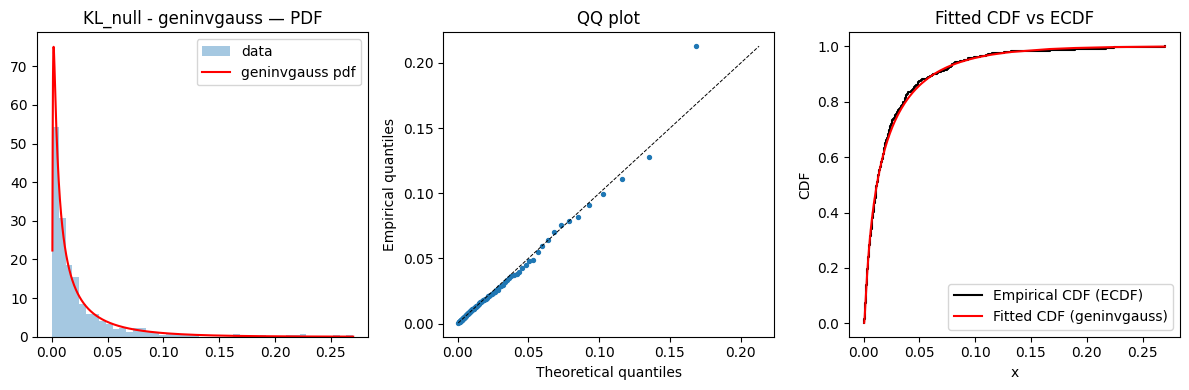

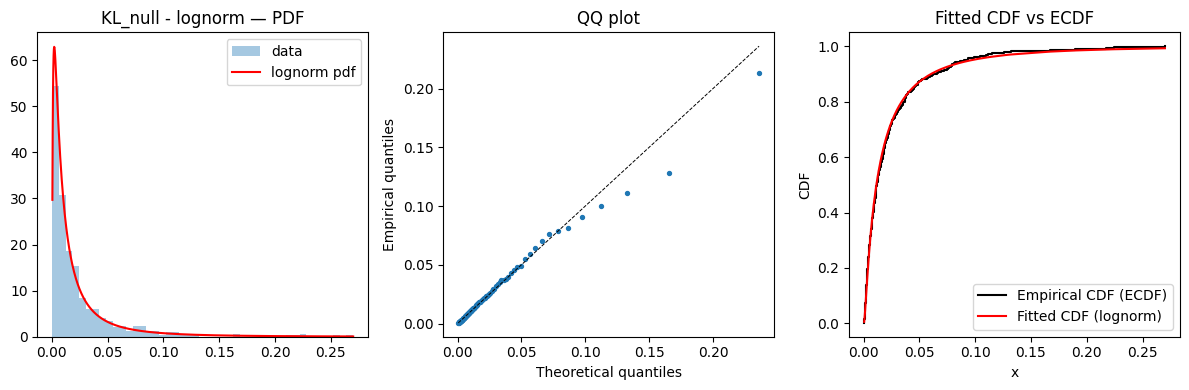

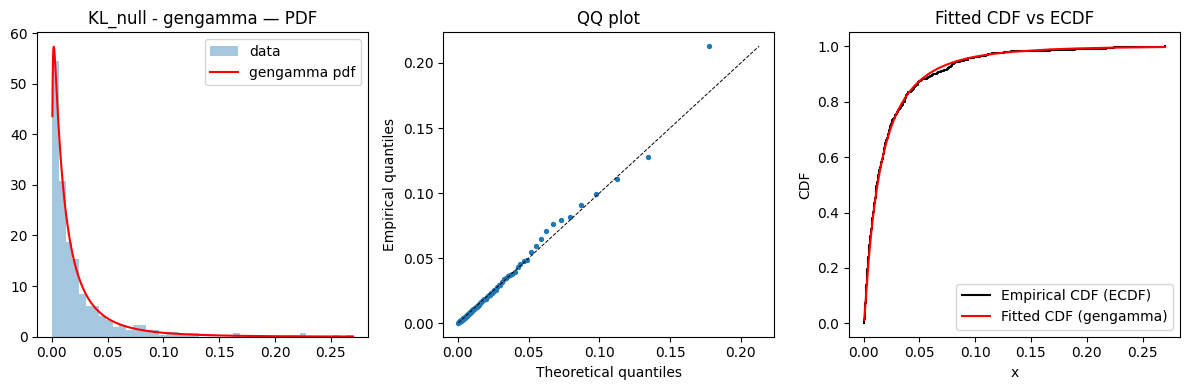

Saved naive summary to: /storage/project/r-ssinha338-0/yhao306/sma/Analysis/MANTIS/regional_associated/KL_null_fit_results/KL_null_naive_fit_summary.csv
Bootstrap top candidates: ['geninvgauss', 'lognorm', 'gengamma']
Bootstrapping geninvgauss n_sim= 1000
Bootstrapping lognorm n_sim= 1000
Bootstrapping gengamma n_sim= 1000


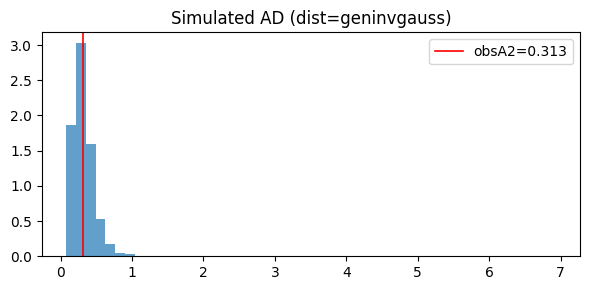

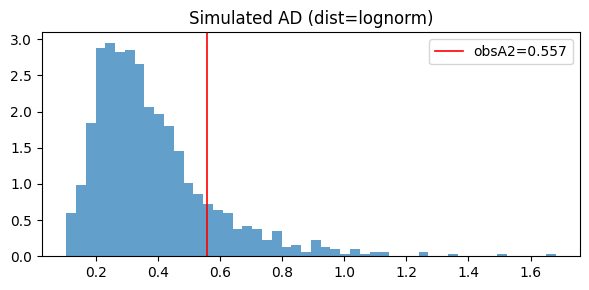

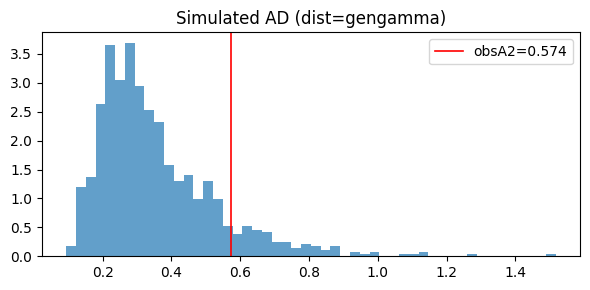

In [54]:
from scipy.stats import kstest
from scipy.stats import chi2, lognorm, gamma, gengamma, weibull_min, fisk, burr, betaprime, geninvgauss
from tqdm import trange
KL_null_varname = "KL_null"
outdir = Path(rmoutdir/"KL_null_fit_results")
outdir.mkdir(exist_ok=True)
candidates = {
    "geninvgauss": geninvgauss,
    "lognorm": lognorm,
    "gengamma": gengamma,
}
DO_BOOTSTRAP = True
n_sim = 1000
RNG_SEED = 12345

def to_numeric_1d(obj):
    import pandas as pd, numpy as np
    if isinstance(obj, pd.Series):
        arr = pd.to_numeric(obj, errors="coerce").to_numpy()
    elif isinstance(obj, pd.DataFrame):
        num = obj.select_dtypes(include=[np.number])
        if num.shape[1] == 0:
            return np.array([], dtype=float)
        arr = pd.to_numeric(num.to_numpy().ravel(), errors="coerce")
    else:
        arr = np.asarray(obj).ravel().astype(float, copy=False)
    arr = arr[np.isfinite(arr)]
    return arr

def ad_statistic_sample(x, cdffunc, eps=1e-12):
    x = np.sort(np.asarray(x, float))
    n = x.size
    u = np.clip(cdffunc(x), eps, 1.0-eps)
    i = np.arange(1, n+1)
    A2 = -n - (1.0/n) * np.sum((2*i - 1) * (np.log(u) + np.log(1.0 - u[::-1])))
    return float(A2)

def _ad_pvalue_naive(A2, n):
    A = A2 * (1.0 + 0.75 / n + 2.25 / (n * n))
    if A < 0.2:
        p = 1.0 - np.exp(-13.436 + 101.14 * A - 223.73 * A * A)
    elif A < 0.34:
        p = 1.0 - np.exp(-8.318 + 42.796 * A - 59.938 * A * A)
    elif A < 0.6:
        p = np.exp(0.9177 - 4.279 * A - 1.38 * A * A)
    else:
        p = np.exp(1.2937 - 5.709 * A + 0.0186 * A * A)
    return float(np.clip(p, 0.0, 1.0)), float(A)

def plot_fit_vs_data(vals, dist, params, title, outpath=None):

    x = np.sort(vals)
    xmin, xmax = x.min(), x.max()
    xx = np.linspace(xmin, xmax, 1000)
    try:
        pdf = dist.pdf(xx, *params)
    except Exception:
        pdf = None

    plt.figure(figsize=(12,4))

    # (1) hist + pdf
    plt.subplot(1,3,1)
    bins = np.histogram_bin_edges(vals, bins='auto')
    plt.hist(vals, bins=bins, density=True, alpha=0.4, label='data')
    if pdf is not None:
        plt.plot(xx, pdf, 'r-', label=f'{dist.name} pdf')
    plt.title(title + " — PDF"); plt.legend()

    # (2) QQ plot
    plt.subplot(1,3,2)
    qs = np.linspace(0.01, 0.99, 100)
    try:
        theo_q = dist.ppf(qs, *params)
        emp_q = np.quantile(vals, qs)
        plt.scatter(theo_q, emp_q, s=8)
        m = np.nanmin([theo_q.min(), emp_q.min()]); M = np.nanmax([theo_q.max(), emp_q.max()])
        plt.plot([m,M],[m,M], 'k--', lw=0.7)
    except Exception:
        plt.text(0.1,0.5, "QQ failed", transform=plt.gca().transAxes)
    plt.title('QQ plot'); plt.xlabel('Theoretical quantiles'); plt.ylabel('Empirical quantiles')

    # (3) CDF vs ECDF
    plt.subplot(1,3,3)
    xs = np.sort(vals)
    n = xs.size
    ecdf_x = xs
    ecdf_y = np.arange(1, n+1) / n
    # fitted CDF evaluated at xs
    try:
        fitted_cdf_at_x = dist.cdf(xs, *params)
        # plot ECDF as step, fitted CDF as line
        plt.step(ecdf_x, ecdf_y, where='post', label='Empirical CDF (ECDF)', color='black')
        plt.plot(xs, fitted_cdf_at_x, '-', label=f'Fitted CDF ({dist.name})', color='red')
        plt.xlabel('x'); plt.ylabel('CDF')
        plt.title('Fitted CDF vs ECDF')
        plt.legend()
    except Exception:
        plt.text(0.1,0.5, "CDF/ECDF plot failed", transform=plt.gca().transAxes)

    plt.tight_layout()
    if outpath:
        plt.savefig(outpath, dpi=160)
    plt.show()

def param_bootstrap_ad_pvals(vals, dist, fit_params, n_sim=1000, floc0=True, rng=None):
    vals = np.asarray(vals, float); n = vals.size
    obs_A2 = ad_statistic_sample(vals, lambda t: dist.cdf(t, *fit_params))
    rng = np.random.default_rng() if rng is None else rng
    sim_A2 = np.empty(n_sim, dtype=float)
    for i in range(n_sim):
        # simulate
        try:
            sim = dist.rvs(*fit_params, size=n, random_state=rng)
        except Exception:
            sim_A2[i] = np.nan; continue
        try:
            if floc0:
                sim_params = dist.fit(sim, floc=0.0)
            else:
                sim_params = dist.fit(sim)
            A2_sim = ad_statistic_sample(sim, lambda t: dist.cdf(t, *sim_params))
            sim_A2[i] = A2_sim
        except Exception:
            sim_A2[i] = np.nan
    sim_A2 = sim_A2[np.isfinite(sim_A2)]
    p_emp = (np.sum(sim_A2 >= obs_A2) + 1.0) / (sim_A2.size + 1.0) if sim_A2.size>0 else np.nan
    return obs_A2, sim_A2, p_emp


vals_null = to_numeric_1d(globals()[KL_null_varname])
print("KL_null n =", vals_null.size)

summary_rows = []
for name, dist in candidates.items():
    try:
        params = dist.fit(vals_null, floc=0.0)
    except Exception:
        try:
            params = dist.fit(vals_null)
        except Exception as e:
            summary_rows.append({
                "dist": name, "error": str(e)
            })
            continue
    try:
        D_obs, p_ks = kstest(vals_null, lambda x: dist.cdf(x, *params))
    except Exception:
        D_obs, p_ks = np.nan, np.nan
    try:
        A2 = ad_statistic_sample(vals_null, lambda t: dist.cdf(t, *params))
        p_ad_naive, A2_star = _ad_pvalue_naive(A2, vals_null.size)
    except Exception:
        A2, p_ad_naive, A2_star = np.nan, np.nan, np.nan

    # store
    summary_rows.append({
        "dist": name,
        "n": int(vals_null.size),
        "params": params,
        "KS_D_naive": float(D_obs) if np.isfinite(D_obs) else np.nan,
        "KS_p_naive": float(p_ks) if np.isfinite(p_ks) else np.nan,
        "AD_A2": float(A2) if np.isfinite(A2) else np.nan,
        "AD_A2_star": float(A2_star) if np.isfinite(A2_star) else np.nan,
        "AD_p_naive": float(p_ad_naive) if np.isfinite(p_ad_naive) else np.nan
    })

    try:
        plot_path = outdir / f"null_{name}_diagnostic.png"
        plot_fit_vs_data(vals_null, dist, params, f"KL_null - {name}", outpath=plot_path)
    except Exception as e:
        print("plot failed for", name, ":", e)

summary_df = pd.DataFrame(summary_rows).set_index("dist")
summary_df.to_csv(outdir / "KL_null_naive_fit_summary.csv")
print("Saved naive summary to:", (outdir / "KL_null_naive_fit_summary.csv").resolve())

if DO_BOOTSTRAP:
    tmp = summary_df.dropna(subset=["AD_p_naive"]).sort_values("AD_p_naive", ascending=False)
    top_k = min(4, tmp.shape[0])
    top_candidates = list(tmp.head(top_k).index)
    print("Bootstrap top candidates:", top_candidates)
    rng = np.random.default_rng(RNG_SEED)
    boot_rows = []
    for name in top_candidates:
        dist = candidates[name]
        params = summary_df.loc[name, "params"]
        print("Bootstrapping", name, "n_sim=", n_sim)
        obsA2, simA2, p_emp = param_bootstrap_ad_pvals(vals_null, dist, params, n_sim=n_sim, floc0=True, rng=rng)
        boot_rows.append({
            "dist": name, "obsA2": obsA2, "n_sim_valid": simA2.size, "AD_p_emp_boot": p_emp
        })
        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(6,3))
            plt.hist(simA2, bins=50, density=True, alpha=0.7)
            plt.axvline(obsA2, color='r', lw=1.2, label=f"obsA2={obsA2:.3f}")
            plt.legend(); plt.title(f"Simulated AD (dist={name})")
            plt.tight_layout()
            # plt.savefig(outdir / f"bootstrap_simA2_{name}.png", dpi=160); plt.close()
        except Exception:
            pass

    # boot_df = pd.DataFrame(boot_rows).set_index("dist")
    # boot_df.to_csv(outdir / "KL_null_bootstrap_ad_pvals.csv")
    # print("Saved bootstrap results to:", (outdir / "KL_null_bootstrap_ad_pvals.csv").resolve())



In [59]:
print(KL)

metabolite
136.06234             0.009218
146.16571             0.018248
146.982305            0.049194
162.11258500000002    0.037989
162.11293999999998    0.035082
                        ...   
966.52592             0.081398
966.549985            0.321594
966.927925            0.025065
992.560465            0.041110
992.614545            0.019613
Name: KL(p||q), Length: 500, dtype: float64


In [60]:
print(KL_null)

metabolite
136.06234             0.000980
146.16571             0.017233
146.982305            0.002493
162.11258500000002    0.043945
162.11293999999998    0.029983
                        ...   
966.52592             0.078214
966.549985            0.076321
966.927925            0.018517
992.560465            0.037000
992.614545            0.004161
Name: KL(p||q), Length: 500, dtype: float64


In [55]:
import numpy as np
import pandas as pd
import warnings
from pathlib import Path
from scipy.stats import geninvgauss

def gig_fit_and_parametric_pvals_for_series(KL_null, KL, alpha=0.05, two_sided=False,
                                            force_floc0=True, clip_min=1e-15,
                                            outdir="KL_gig_parametric_results",
                                            save_csv=True):

    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)

    def to_series(x):
        if isinstance(x, pd.Series):
            s = x.dropna().astype(float)
            return s
        if isinstance(x, pd.DataFrame):
            if x.shape[1] == 1:
                s = x.iloc[:,0].dropna().astype(float)
                return s
            raise ValueError("KL / KL_null DataFrame must be single-column for this function.")
        arr = np.asarray(x).ravel()
        return pd.Series(arr[np.isfinite(arr)], index=np.arange(len(arr))[~np.isnan(arr)].tolist()).astype(float)

    s_null = to_series(KL_null)
    s_real = to_series(KL)

    if s_null.size == 0:
        raise ValueError("KL_null has no finite values.")
    if s_real.size == 0:
        raise ValueError("KL (real) has no finite values.")

    n_before = s_null.size
    s_null_clipped = s_null.copy()
    if (s_null_clipped <= 0).any():
        s_null_clipped = s_null_clipped.clip(lower=clip_min)
    n_after = s_null_clipped.size

    gig_params = None
    gig_fit_error = None
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            if force_floc0:
                gig_params = geninvgauss.fit(s_null_clipped.values, floc=0.0)
            else:
                gig_params = geninvgauss.fit(s_null_clipped.values)
    except Exception as e:
        gig_fit_error = str(e)
        gig_params = None

    if gig_params is not None:
        p_hat, b_hat, loc_hat, scale_hat = gig_params
        print(f"Fitted pooled GIG params: p={p_hat:.6g}, b={b_hat:.6g}, loc={loc_hat:.6g}, scale={scale_hat:.6g}")
    else:
        print("GIG fit failed:", gig_fit_error)

    obs = s_real.copy()
    p_right = pd.Series(index=obs.index, dtype=float)
    p_two = pd.Series(index=obs.index, dtype=float)

    if gig_params is None:
        p_right[:] = np.nan
        p_two[:] = np.nan
    else:
        for idx, val in obs.items():
            if not np.isfinite(val):
                p_right.loc[idx] = np.nan
                p_two.loc[idx] = np.nan
                continue
            x = max(val, clip_min)
            try:
                logsf = geninvgauss.logsf(x, *gig_params)
                logsf_clipped = np.maximum(logsf, np.log(np.finfo(float).tiny))
                pv = float(np.exp(logsf_clipped))
                p_right.loc[idx] = pv
                if two_sided:
                    cdfv = geninvgauss.cdf(x, *gig_params)
                    pv2 = 2.0 * min(cdfv, 1.0 - cdfv)
                    p_two.loc[idx] = float(pv2)
                else:
                    p_two.loc[idx] = np.nan
            except Exception as e:
                p_right.loc[idx] = np.nan
                p_two.loc[idx] = np.nan

    def bh(pseries):
        p = pseries.to_numpy(dtype=float)
        mask = np.isfinite(p)
        q = np.full_like(p, np.nan, dtype=float)
        if mask.sum() > 0:
            psub = p[mask]
            order = np.argsort(psub)
            ranks = np.arange(1, len(psub)+1)
            qsub = psub[order] * len(psub) / ranks
            qsub = np.minimum.accumulate(qsub[::-1])[::-1]
            qsub = np.clip(qsub, 0, 1)
            tmp = np.empty_like(psub)
            tmp[order] = qsub
            q[mask] = tmp
        return pd.Series(q, index=pseries.index)

    q_right = bh(p_right)
    q_two = None
    if two_sided:
        q_two = bh(p_two)

    df = pd.DataFrame({
        "obs": obs,
        "p_gig_right": p_right,
        "q_gig_right": q_right
    }, index=obs.index)
    if two_sided:
        df["p_gig_two_sided"] = p_two
        df["q_gig_two_sided"] = q_two

    df["significant_gig_right"] = df["q_gig_right"] < float(alpha)

    if save_csv:
        outpath = Path(outdir) / "KL_parametric_pvalues_gig.csv"
        df.sort_values("p_gig_right").to_csv(outpath)
        print("Saved results to:", outpath.resolve())

    total = df.shape[0]
    n_sig = int(df["significant_gig_right"].sum())
    prop = n_sig / total if total>0 else np.nan
    print(f"Pooled null N = {s_null_clipped.size}")
    print(f"Tested metabolites = {total}")
    print(f"Parametric (GIG) significant (BH q < {alpha}) = {n_sig} ({prop:.2%})")

    sig_list = df.index[df["significant_gig_right"]].tolist()
    return df, {"n_pooled_null": int(s_null_clipped.size), "n_tested": total,
                "n_significant": n_sig, "prop_significant": prop, "sig_list": sig_list,
                "gig_params": gig_params, "gig_fit_error": gig_fit_error}


results_df, summary = gig_fit_and_parametric_pvals_for_series(
    KL_null=KL_null,
    KL=KL,
    alpha=0.1,
    two_sided=False,
    force_floc0=True,
    clip_min=1e-15,
    outdir=rmoutdir/"KL_gig_parametric_results",
    save_csv=True
)

print(results_df.head(20))
print("\nSummary:", summary)
print("\nSignificant metabolites:", summary["sig_list"])


Fitted pooled GIG params: p=0.116702, b=0.29638, loc=0, scale=0.00929342
Saved results to: /storage/project/r-ssinha338-0/yhao306/sma/Analysis/MANTIS/regional_associated/KL_gig_parametric_results/KL_parametric_pvalues_gig.csv
Pooled null N = 500
Tested metabolites = 500
Parametric (GIG) significant (BH q < 0.1) = 66 (13.20%)
                         obs  p_gig_right  q_gig_right  significant_gig_right
metabolite                                                                   
136.06234           0.009218     0.565316     0.614473                  False
146.16571           0.018248     0.381035     0.476294                  False
146.982305          0.049194     0.144664     0.330820                  False
162.11258500000002  0.037989     0.198295     0.357325                  False
162.11293999999998  0.035082     0.216237     0.360222                  False
163.11623           0.033642     0.225922     0.365569                  False
165.066415          0.014198     0.448832     0.5

In [59]:
import pandas as pd
from pathlib import Path

outdir = Path(rmoutdir/"KL_gig_parametric_results")
outdir.mkdir(exist_ok=True, parents=True)


sig_col = None
candidates = ["significant_gig_right", "significant_emp_pooled", "significant_emp", "significant_gig", "significant"]
for c in candidates:
    if c in results_df.columns:
        sig_col = c
        break


mask = results_df[sig_col].astype(bool)
sig_df = results_df.loc[mask].copy()

full_path = rmoutdir / "significant_results_full.csv"
sig_df.to_csv(full_path)
list_path = rmoutdir / "significant_metabolites_list.csv"
pd.Series(sig_df.index.tolist(), name="metabolite").to_csv(list_path, index=False)

print(f"number of significant metabolite: {len(sig_df)} / {len(results_df)}")
print("Saved as:")
print(" - complete significant rows:", full_path.resolve())
print(" - significant:", list_path.resolve())

display(sig_df.head())

number of significant metabolite: 66 / 500
Saved as:
 - complete significant rows: /storage/project/r-ssinha338-0/yhao306/sma/Analysis/MANTIS/regional_associated/significant_results_full.csv
 - significant: /storage/project/r-ssinha338-0/yhao306/sma/Analysis/MANTIS/regional_associated/significant_metabolites_list.csv


,obs,p_gig_right,q_gig_right,significant_gig_right
metabolite,,,,
342.33635000000004,0.237143,0.002614,0.076009,True
343.05333,0.215859,0.003932,0.076009,True
352.971175,0.426566,0.000082,0.020377,True
381.009,0.275309,0.001273,0.063657,True
415.22112500000003,0.175748,0.008636,0.092916,True


In [60]:
list= pd.read_csv(rmoutdir/"significant_metabolites_list.csv")

In [61]:
print(list)

    metabolite
0   342.336350
1   343.053330
2   352.971175
3   381.009000
4   415.221125
..         ...
61  868.620070
62  868.644580
63  868.654725
64  942.585960
65  966.549985

[66 rows x 1 columns]
